# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.utils.multiclass import unique_labels
from scipy import stats
from time import time
import os, math, time, random, datetime
import warnings; warnings.simplefilter('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Load the dataset

In [ ]:
# load the data  --> NOTE: this works only in the UDacity projecdt workspace

# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [2]:
# load the data --> NOTE: this works in my (and your) local environment, and it runs much faster!

azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

### 0.2 Explore the AZDIAS dataset

We start by looking at the AZDIAS dataset. We will use a few popular dataframe functions to learn about the data.

In [3]:
df_azdias = azdias.copy() # use this for exploring and analyzing the dataset
df_azdias_prep = azdias.copy() # use this later for the data cleaning implementation

In [4]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
df_azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [6]:
df_azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
# get the size of the dataset
df_azdias.shape

(891221, 366)

In [8]:
# get a sense of the dataset's null value status
df_azdias.isnull().sum().sort_values(ascending = False)

ALTER_KIND4                  890016
ALTER_KIND3                  885051
ALTER_KIND2                  861722
ALTER_KIND1                  810163
EXTSEL992                    654153
                              ...  
D19_VERSAND_ANZ_24                0
D19_VERSAND_DATUM                 0
D19_VERSAND_OFFLINE_DATUM         0
D19_VERSAND_ONLINE_DATUM          0
ALTERSKATEGORIE_GROB              0
Length: 366, dtype: int64

In [9]:
# function to visualize the null value status of the dataset

def show_null_stats(df, name, top_X):
    """
    Input:
        df = dataset to be analyzed
        name = name of the dataset
        top_X = number of columns to visualize
    Output:
        Plot the given top_X columns with the highest percent of null values
    """
    
    df_isnull = df.isnull().sum()
    df_null_ratio = df_isnull / len(df) * 100
    
    # show null column counts
    plt.subplots_adjust(hspace=40.0, top = 0.9)
    fig = plt.figure()
    
    ax = fig.add_subplot(311)
    ax = df_isnull.sort_values(ascending=False)[:top_X].plot(kind='bar', figsize=(15, 15),
                                                    title='Top {} null columns'.format(top_X))
    plt.xticks(rotation = 45)
    ax.set_xlabel("Columns of {}".format(name))
    ax.set_ylabel("# of Null columns")
    
    # show percent of null values of columns
    ax = fig.add_subplot(312)
    ax = df_null_ratio.sort_values(ascending=False).head(top_X).plot(kind='bar', figsize=(15, 15),
                                                    title='Top {} null ratio columns'.format(top_X))
    plt.xticks(rotation = 45)
    ax.set_xlabel("Columns of {}".format(name))
    ax.set_ylabel("Null ratio [%]")
    
    # show null value proportion
    ax = fig.add_subplot(313)
    plt.hist(df_null_ratio, bins=50);
    plt.xlabel('Null value proportion in the column')
    plt.ylabel('# of columns')
    plt.title('Proportion of null values')
    
    plt.subplots_adjust(hspace=2.0)

<Figure size 432x288 with 0 Axes>

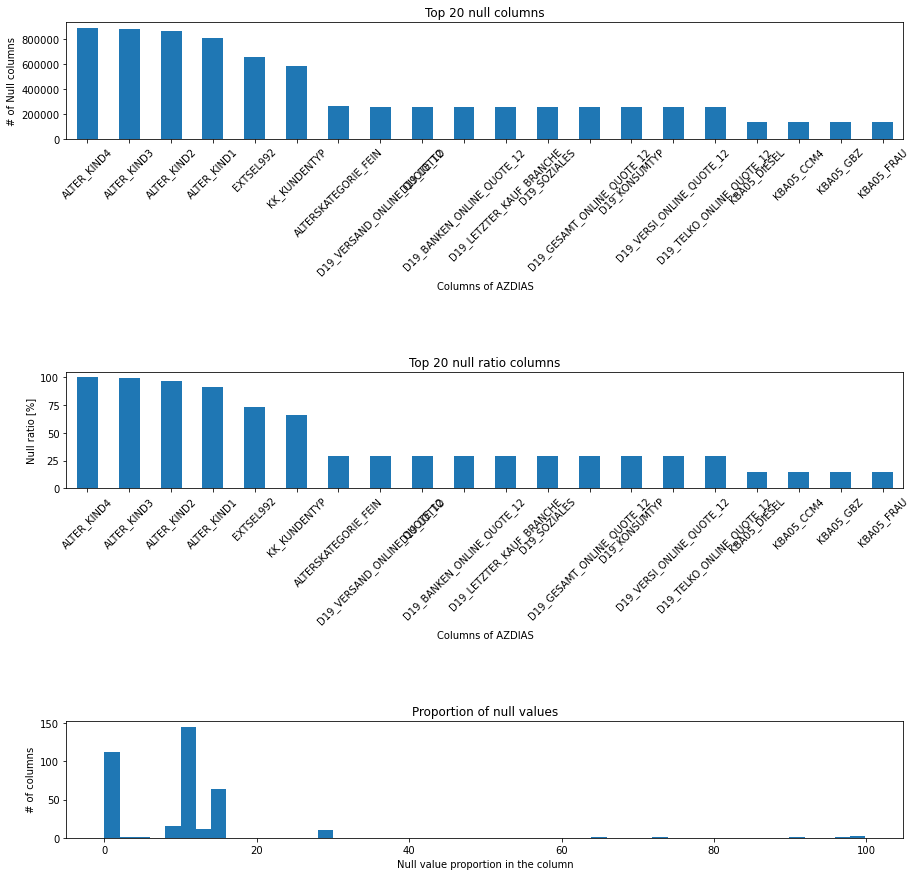

In [10]:
show_null_stats(df_azdias, 'AZDIAS', 20)

### 0.3 Explore the CUSTOMERS dataset

In [11]:
df_customers = customers.copy()  # use this for exploring and analyzing the dataset
df_customers_prep = customers.copy() # use this later for actual data cleaning implementation

In [12]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [13]:
df_customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [14]:
df_customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [15]:
# get the size of the dataset
df_customers.shape

(191652, 369)

In [16]:
# get a sense of the dataset's null value status
df_customers.isnull().sum().sort_values(ascending = False)

ALTER_KIND4                  191416
ALTER_KIND3                  190377
ALTER_KIND2                  186552
ALTER_KIND1                  179886
KK_KUNDENTYP                 111937
                              ...  
D19_VERSAND_ANZ_24                0
D19_VERSAND_DATUM                 0
D19_VERSAND_OFFLINE_DATUM         0
D19_VERSAND_ONLINE_DATUM          0
ALTERSKATEGORIE_GROB              0
Length: 369, dtype: int64

<Figure size 432x288 with 0 Axes>

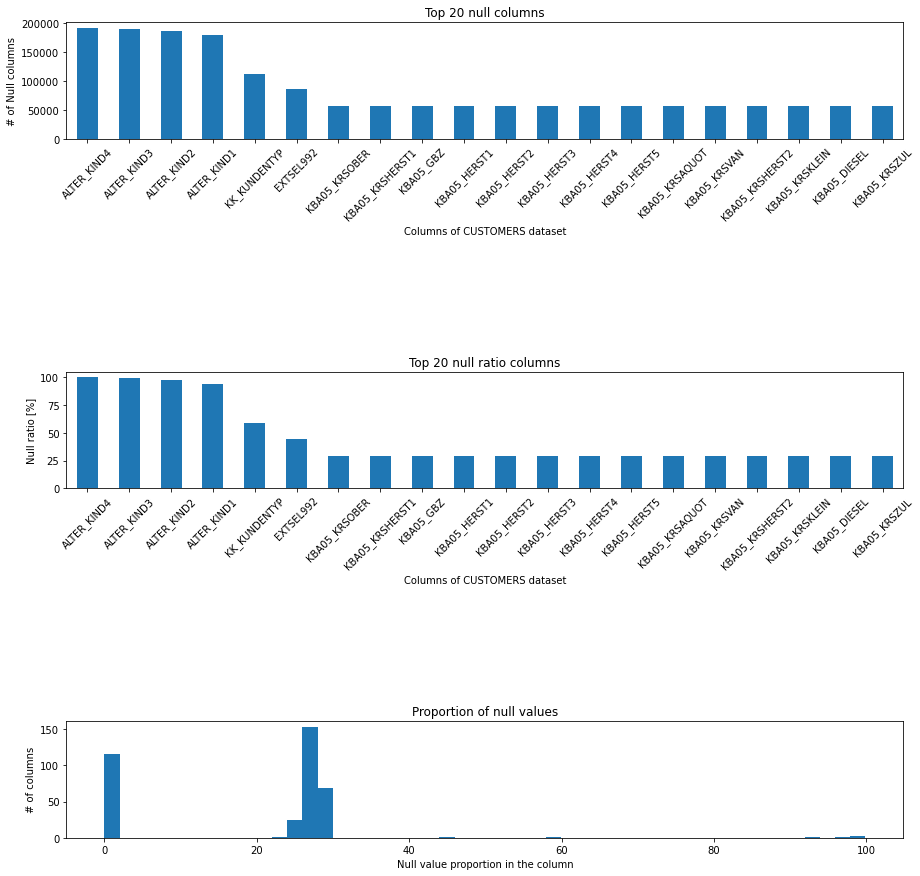

In [17]:
show_null_stats(df_customers, 'CUSTOMERS dataset', 20)

### 0.4 Upload and explore attributes information

In [18]:
# read Excel files 'DIAS Attributes - Values 2017.xlsx' and 'DIAS Information Levels - Attributes 2017.xlsx'
attr_val = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
attr_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])

In [19]:
attr_val.shape, attr_info.shape

((2258, 5), (313, 5))

In [20]:
df_attr_val = attr_val.copy()
df_attr_info = attr_info.copy()

In [21]:
df_attr_val.drop(columns=['Unnamed: 0'], inplace=True)
df_attr_info.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
df_attr_val.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [23]:
# count the null values
df_attr_val.isnull().sum()

Attribute      1944
Description    1907
Value             0
Meaning          11
dtype: int64

In [24]:
# handle the null values the df_attr_val dataset 
df_attr_val.fillna(method='ffill')

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [25]:
df_attr_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### 0.5 Pre-process the data

**0.5.1** What is a good missing value threshold to drop columns?

In [26]:
# test out AZDIAS dataset

azdias_null_ratio = df_azdias.isnull().sum() / len(df_azdias)
azdias_null_val = pd.DataFrame({'null_rate': azdias_null_ratio})
(azdias_null_val['null_rate'] < 0.3).mean()

0.9836065573770492

In [27]:
# test out CUSTOMERS dataset

customers_null_ratio = df_customers.isnull().sum() / len(df_customers)
customers_null_val = pd.DataFrame({'null_rate': customers_null_ratio})
(customers_null_val['null_rate'] < 0.3).mean()

0.983739837398374

**Observation**: for both AZDIAS and CUSTOMERS datasets, there are 98% of columns that have less than 30 percent of missing values.  We decide to drop columns that have 30% or more missing values 

In [28]:
# function to drop a number of columns based on selected null value ratio threshold

def drop_cols(df, threshold):
    """
    Input:
        df = dataset to be processed
        threshold = column's null value ratio
    Output:
        columns to drop based on the threshold
    """
    df_isnull = df.isnull().sum()
    df_null_ratio = df_isnull / len(df) * 100
    df_null_ratio = df_null_ratio[df_null_ratio >= threshold].index
    
    return df_null_ratio

In [29]:
# threshold = 30
to_drop_az_highnull = drop_cols(df_azdias, 30)
to_drop_az_highnull

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [30]:
# threshold = 30
to_drop_cs_highnull = drop_cols(df_customers, 30)
to_drop_cs_highnull

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

**0.5.2** Find out the 3 extra columns in the CUSTOMERS dataset that are not in the AZDIAS dataset.  They will be dropped during data cleaning implementation

In [31]:
set(df_customers.columns.values) - set(df_azdias.columns.values)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [32]:
df_customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

**0.5.3** Analyze columns with object datatype so we get prepared for encoding in data cleaning later

In [33]:
# find columns with object data type
df_azdias.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [34]:
print('# unique values of column D19_LETZTER_KAUF_BRANCHE: ' + 
      str(len(df_azdias['D19_LETZTER_KAUF_BRANCHE'].unique())))
print('# unique values of column EINGEFUEGT_AM: ' + str(len(azdias['EINGEFUEGT_AM'].unique())))
print('# unique values of column OST_WEST_KZ: ' + str(len(azdias['OST_WEST_KZ'].unique())))

# unique values of column D19_LETZTER_KAUF_BRANCHE: 36
# unique values of column EINGEFUEGT_AM: 5163
# unique values of column OST_WEST_KZ: 3


We will want to drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM' in the data cleaning implementation later

In [35]:
df_azdias[['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015']].isnull().sum()

CAMEO_DEU_2015     98979
CAMEO_DEUG_2015    98979
CAMEO_INTL_2015    98979
dtype: int64

In [36]:
df_azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [37]:
df_azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [38]:
df_azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

**Observation** The columns CAMEO_DEU_2015','CAMEO_DEUG_2015'and 'CAMEO_INTL_2015'
-  have lots of null values, we want to fill the null values in the data cleaning implementation stage
-  have mixed value types, we want to replace X and XX in the data cleaning stage implementation stage

**0.5.4** Analyze features correlation

In many datasets we find some of the features which are highly correlated that means which are some what linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost

Reference:  https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

In [39]:
corr_matrix = df_azdias.corr().abs()

In [40]:
# drop columns with high correlation (here, we consider .8 as a threshold for high correlation)

print('# cols before correlation drop: ', len(df_azdias.columns))
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df_azdias = df_azdias.drop(to_drop, axis=1)
print('# cols after correlation drop: ', len(df_azdias.columns))

# cols before correlation drop:  366
# cols after correlation drop:  303


In [41]:
corr_matrix = df_customers.corr().abs()

In [42]:
# drop columns with high correlation (here, we consider .8 as a threshold for high correlation)

print('# cols before correlation drop: ', len(df_customers.columns))
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df_customers = df_customers.drop(to_drop, axis=1)
print('# cols after correlation drop: ', len(df_customers.columns))

# cols before correlation drop:  366
# cols after correlation drop:  300


In [43]:
df_azdias.shape, df_customers.shape

((891221, 303), (191652, 300))

**0.5.5** Analyze unknowns

By cross comparing the 'DIAS Attributes - Values 2017.xlsx' dataset, we find there are a few values that are mapped
to 'unknown' in their corresponding 'Meaning' column.  We will replace these values by NaN in the data cleaning stage

In [44]:
unknown = df_attr_val[(df_attr_val['Meaning'].str.contains('unknown', na=False))]

In [45]:
unknown['Value'].unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

Based on the analysis above, we want to replace fields that have -1, 0, 9 that are marked as unknown by NaN in the data cleaning step

**0.5.6** Check remaining NaN value status

In [46]:
df_azdias.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
W_KEIT_KIND_HH          107602
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ALTERSKATEGORIE_GROB         0
Length: 303, dtype: int64

In [47]:
df_customers.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               46596
ALTER_HH                 46596
ALTER_KIND1             179886
                         ...  
WOHNDAUER_2008           46596
WOHNLAGE                 49927
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 300, dtype: int64

***Observation**: at this step, both datasets still have lots of null values, we can use imputing to handle them in the data cleaning stage

### 0.6 Put data cleaning all together

In [48]:
# function to clean the dataset

def data_cleaning(df, df_name=None):
    """
    Input:
        df = dataset to be cleaned
        df_name = name of the dataset
    Output:
        cleaned dataset that is ready for further analysis
    """
    
    # drop the 3 extra unique columns in customers dataset
    if df_name == 'df_customers':            
        df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    # drop columns with more than 30% nulls in azdias    
    df = df.drop(drop_cols(df, 30), axis =1)
    
    # drop columns that have too many unique values 
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
        
    
    # handle columns with high correlation
    # creat correlation matrix   
    corr_matrix = df.corr().abs()
    
    # select upper trigular matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # drop columns with high correlation (here, we consider .8 as a threshold for high correlation)
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > .8)]
    df = df.drop(to_drop, axis=1)
    
    
    # encode features with object data type
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
       
    # handle unknowns   
    # fill missing values with -1 for fields that have -1 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)

    # fill missing values with 0 for fields that have 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)
    
    # fill missing values with 9 for fields that have 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)
    
    # covert objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    df_columns = list(df.columns.values)
    

    # impute missing values with Mode 
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    

    #scale and standardize the dataset
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    
    return df

In [49]:
# clean the azdias dataset
df_azdias_clean = data_cleaning(df_azdias_prep, 'azdias')

In [50]:
df_azdias_clean.shape

(891221, 341)

In [51]:
df_azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,1.060942,-0.535207,1.133421,-1.261061,-1.276680,-0.494589,-0.118316,-0.292527,-1.315651,-0.057885,...,-0.250034,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.020462
1,1.060961,-0.535207,1.133421,-1.261061,1.499160,0.238520,-0.118316,-0.292527,0.344310,-0.057885,...,3.999464,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.020462
2,1.060981,-0.535207,1.133421,0.889590,0.970428,0.171874,-0.118316,-0.292527,-0.485671,-0.057885,...,-0.250034,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.020462
3,1.060984,1.967456,-1.025210,0.383554,0.441697,-0.427942,-0.118316,-0.292527,-1.315651,-0.057885,...,-0.250034,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.020462
4,1.061043,-0.535207,-1.025210,1.269116,0.573880,-0.294650,-0.118316,-0.292527,2.004271,-0.057885,...,-0.250034,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.020462


In [52]:
# clean the customers dataset 
df_customers_clean = data_cleaning(df_customers_prep, 'customers')

In [53]:
df_customers_clean.shape

(191652, 347)

In [54]:
df_customers_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER
0,-1.558070,1.189681,-0.707188,0.192466,0.425338,-0.213830,-0.105218,-0.238379,0.182645,-0.116283,...,-0.069338,-0.071949,-0.10157,-0.089055,-0.025649,-0.541140,0.948777,-0.573085,0.670295,-0.670295
1,-1.558034,-0.966005,1.546074,0.329163,-1.301488,-0.293849,-0.105218,-0.238379,0.826795,-0.116283,...,-0.069338,-0.071949,-0.10157,-0.089055,-0.025649,-0.541140,-1.053988,1.744943,-1.491879,1.491879
2,0.868420,-0.966005,-0.707188,-0.354319,-1.301488,-0.213830,-0.105218,-0.238379,-0.461504,-0.116283,...,-0.069338,-0.071949,-0.10157,-0.089055,-0.025649,-0.541140,0.948777,-0.573085,0.670295,-0.670295
3,0.868438,0.471119,-0.707188,-0.080926,0.079973,-0.293849,-0.105218,-0.238379,-1.105653,-0.116283,...,-0.069338,-0.071949,-0.10157,-0.089055,-0.025649,1.847952,-1.053988,-0.573085,0.670295,-0.670295
4,0.868456,-0.966005,-0.707188,1.559431,1.116069,0.266288,-0.105218,-0.238379,1.470944,-0.116283,...,-0.069338,-0.071949,-0.10157,-0.089055,-0.025649,-0.541140,-1.053988,1.744943,0.670295,-0.670295


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 PCA Analysis

The datasets we use have lots of features. It could take impossibly long model training time to complete the analysis. We want to transform high-dimensions data to lower-dimensions while retaining as much information as possible. Therefore, let's use the Principle Component Analysis (PCA) method.  

In [55]:
# find the optimized number of components to keep

def plot_min_pcom(df, percent, data_name=None):
    pca = PCA().fit(df)
    plt.figure(figsize=(8,4))
    
    pca_weight = pca.explained_variance_ratio_
    pca_perc = np.cumsum(pca_weight)
    
    # get the min number of principal components that perserves more than desired variance percentage
    pca_num = np.where(pca_perc>=percent)[0][0]
    
    # visualize Cumulative Explained Variance vs Number of Components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Explained Variance - {}'.format(data_name))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(pca_num, c='b', linestyle = 'dotted')
    plt.axhline(percent, c='r', linestyle = 'dotted')
    plt.show()

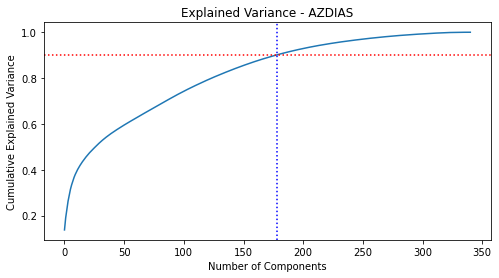

In [56]:
# let's see what the visualization look like if we want to preserve 90% of variance
plot_min_pcom(df_azdias_clean, 0.9, 'AZDIAS')

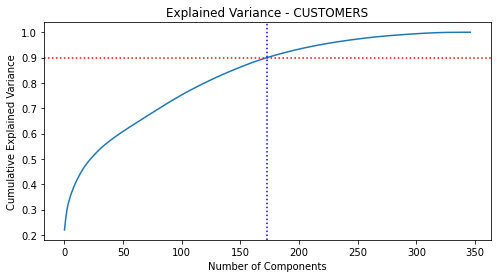

In [57]:
# let's see what the visualization look like if we want to preserve 90% of variance
plot_min_pcom(df_customers_clean, 0.9, 'CUSTOMERS')

**Observation**: From the visualization above, we can preserve **90%** of the variance by reducing the number of components from more than 300 to less than 200. Let's keep **180** components for this analysis. 

In [58]:
# reduce high-dimentional dataset to lower-dimentional dataset

def reduce_dimensions(df, n = None):
    """
    Input:
        df = dataset to be processed
        n = number of components
    Output:
        new dataset with reduced dimensions
    """
    
    pca = PCA(n_components=n).fit(df)    
    pca_reduced = pd.DataFrame(pca.transform(df))
    
    print('Percentage of variance explained with reduced components {}: '.format(pca.explained_variance_ratio_.sum()))

    return pca_reduced

In [59]:
# reduce the azdias dataset and preint the preserved variance ratio score
reduced_azdias = reduce_dimensions(df_azdias_clean, 180)

Percentage of variance explained with reduced components 0.9015406775429244: 


In [60]:
# reduce the customers dataset and print the preserved variance ratio score
reduced_customers = reduce_dimensions(df_customers_clean, 180)

Percentage of variance explained with reduced components 0.9075717213155874: 


**Observation**: by reducing the number of components to 180, we are able to preserve ~90% of the variance

### 1.2 KMeans Clustering

Now, let's use the **elbow method** to determin the optimal number of clusters 

The idea is to run k-means clustering on a given dataset for a range of values of k, and for each value of k, calculate sum of squared errors (SSE).  After that, we plot a line graph of the SSE for each value of k. Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k.  Our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In [61]:
def plot_optimal_cluster(df, name = None):
    '''
    Input:
        df = dataset to be processed
        name = name of the datasest
    Output:
        new dataset with reduced dimensions
    '''
    
    sse = {}
    for k in range(1, 20, 1):
        kmeans = KMeans(n_clusters=k, max_iter=300).fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure(figsize=(12,6))
    plt.plot(list(sse.keys()), list(sse.values()), linestyle='--', marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Number of clusters vs SSE - {}'.format(name))
    plt.grid()
    plt.show()

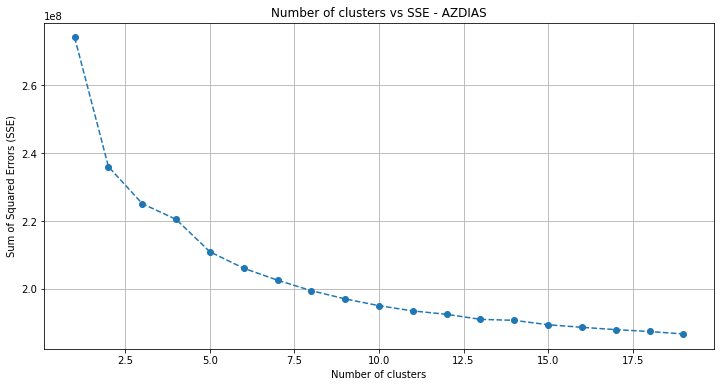

In [62]:
plot_optimal_cluster(reduced_azdias, 'AZDIAS')

**Observation**: The above visualzation shows the SSE slop decreases with a high slope until around 9 clusters. We choose **K = 9** as the elbow of the curve.  

Next, we should run K-Means clustering for the 9 clusters of each dataset

In [63]:
def run_kmeans(df, k = None):
    '''
    Input:
        df = dataset to be processed
        k = number of clusters
    Output:
        predicted clusters and value counts of the clusters 
    '''
    
    # create clusters
    kmeans = KMeans(n_clusters=k)
    # kmeans = MiniBatchKMeans(n_clusters=k)
    
    # create model and run prediction
    df_predict = kmeans.fit_predict(df)
    
    df_clusters = pd.Series(df_predict)
    df_clusters = df_clusters.value_counts().sort_index()
    
    return df_predict, df_clusters

In [64]:
azdias_predict, azdias_clusters = run_kmeans(reduced_azdias, 9)

In [65]:
customers_predict, customers_clusters = run_kmeans(reduced_customers, 9)

In [66]:
azdias_ratio = pd.DataFrame({'cluster':  np.unique(azdias_predict),
                                'count':  np.bincount(azdias_predict), 
                                'ratio %': (np.bincount(azdias_predict)/azdias_predict.shape[0]*100).round(2)})
azdias_ratio['data']='AZDIAS (General Population)'

customers_ratio = pd.DataFrame({'cluster':  np.unique(customers_predict),
                                'count':  np.bincount(customers_predict), 
                                'ratio %': (np.bincount(customers_predict)/customers_predict.shape[0]*100).round(2)})
customers_ratio['data'] = 'CUSTOMERS'

In [67]:
cluster_info = pd.DataFrame([])

cluster_info['Population'] = azdias_clusters
cluster_info['Customers'] = customers_clusters
cluster_info['Percent Azdias'] = azdias_ratio['ratio %']
cluster_info['Percent Customers'] = customers_ratio ['ratio %']
cluster_info['Diff'] = customers_ratio['ratio %'] - azdias_ratio['ratio %']

cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={'index':'Cluster'}, inplace=True)

In [68]:
cluster_info

,Cluster,Population,Customers,Percent Azdias,Percent Customers,Diff
0,0,69096,7074,7.75,3.69,-4.06
1,1,188686,13106,21.17,6.84,-14.33
2,2,57347,48906,6.43,25.52,19.09
3,3,133751,22743,15.01,11.87,-3.14
4,4,34087,37658,3.82,19.65,15.83
5,5,156681,24516,17.58,12.79,-4.79
6,6,137550,19560,15.43,10.21,-5.22
7,7,99237,17156,11.13,8.95,-2.18
8,8,14786,933,1.66,0.49,-1.17


[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'No. of People')]

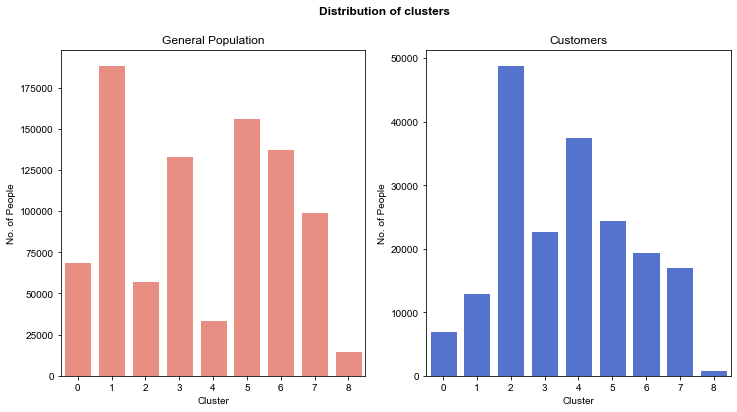

In [69]:
# compare the proportion of data in each cluster of each dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
fig.suptitle('Distribution of clusters', fontweight='bold')
sns.set_style('darkgrid')

# general population
sns.barplot(ax=axes[0], data = cluster_info, x = 'Cluster', y= 'Population', color = 'salmon')
axes[0].set_title('General Population')
axes[0].set(xlabel = 'Cluster', ylabel = 'No. of People')

# customers
sns.barplot(ax=axes[1], data = cluster_info, x = 'Cluster', y= 'Customers', color = 'royalblue')
axes[1].set_title('Customers')
axes[1].set(xlabel = 'Cluster', ylabel = 'No. of People')

Text(0.5, 1.0, 'Proportion of clusters - general population vs customers ')

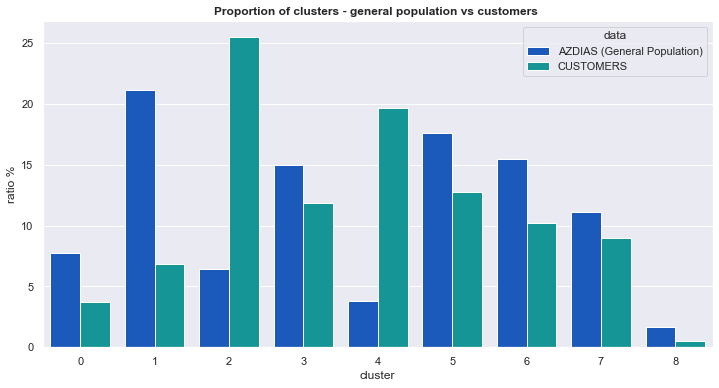

In [70]:
# combine all the azdias and customer cluster data to compare
combined_clusters_ratio = pd.concat([azdias_ratio, customers_ratio])

sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(data=combined_clusters_ratio, x = 'cluster', y = 'ratio %', hue='data', 
            palette= 'winter').set_title('Proportion of clusters - general population vs customers ', 
                                   fontdict= {'fontweight':'bold'})

**OBSERVATION**: In this particular run above, 
- Customers are mostly from clusters 2 and 4 (results could be different in a new run) 
- General population are distributed across all clusters
- At the same scale, the ratio of customer proportion is higher than that of general population in clusters 2 and 4.  
  This tells us these 2 clusters contain more customers, and they can be target for future customers. (results could
  be different in a new run) 

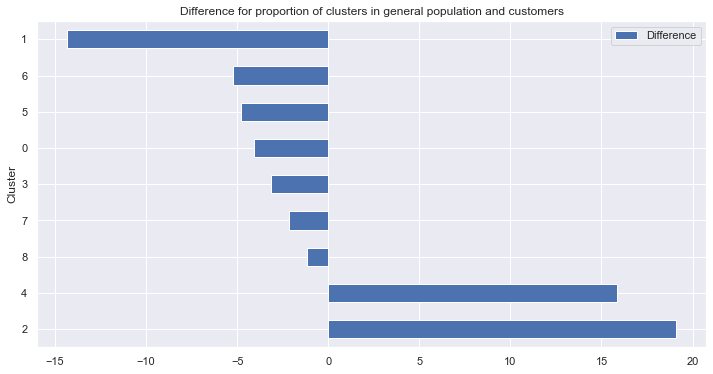

In [71]:
cluster_info_sorted = cluster_info.sort_values(by= 'Diff', ascending=False)

cluster_info_sorted.plot.barh(x='Cluster', y='Diff', label='Difference', 
                       title='Difference for proportion of clusters in general population and customers')

plt.show()

In [72]:
pca = PCA(n_components = 180).fit(df_azdias_clean)

In [73]:
# function to show the top and bottom weights of a given component 
def show_pca_weights(pca,component,weight):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = df_azdias_clean.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1, keys=ratio.index)
    result[:5]
    
    print("Principal Component: ", component)   
    print('\n')
    
    print("Positive weights - top {}:".format(weight))
    print(result.iloc[(component)-1].sort_values(ascending=False)[:weight])
    print('\n')
    print("Negative weights - bottom {}:".format(weight))
    print(result.iloc[(component)-1].sort_values()[:weight])
          

In [88]:
# now look at componet (cluster) 2 which is the highest customer positively represented component 
# show the top and bottom 5 weights 
show_pca_weights(pca,2,5)

Principal Component:  2


Positive weights - top 5:
1  LP_STATUS_FEIN       0.164
   MOBI_RASTER          0.158
   KBA05_GBZ            0.148
   FINANZ_MINIMALIST    0.143
   KBA05_ANTG1          0.137
Name: 1, dtype: float64


Negative weights - bottom 5:
1  KBA13_BAUMAX         -0.155
   KBA13_ANTG4          -0.152
   KBA13_ANTG3          -0.142
   HH_EINKOMMEN_SCORE   -0.140
   FINANZ_HAUSBAUER     -0.133
Name: 1, dtype: float64


In [89]:
# now look at componet (cluster) 4 which is the second highest customer positively represented component
# show the top and bottom 5 weights 
show_pca_weights(pca,4,5)

Principal Component:  4


Positive weights - top 5:
1  CJT_TYP_1                0.162
   KBA13_HERST_BMW_BENZ     0.160
   FINANZ_UNAUFFAELLIGER    0.158
   FINANZ_SPARER            0.156
   SEMIO_TRADV              0.145
Name: 3, dtype: float64


Negative weights - bottom 5:
1  CJT_TYP_3              -0.162
   CJT_TYP_6              -0.152
   CJT_TYP_5              -0.150
   ALTERSKATEGORIE_GROB   -0.148
   CJT_TYP_4              -0.147
Name: 3, dtype: float64


**Discussion**
By identifying the 2 positively represented components and by crossing checking the description of their top weights,
we can conclude the target customers share a few common attributes,
- have low financial interest
- have number of 1-2 family houses
- money savers
- traditional minded
- share BMW & Mercedes Benz within the PLZ8

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Create and train the models, compare prediction performance among selected models

In [ ]:
# un-comment the line below if the code is running in the UDacity project workspace

# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [76]:
# Use this line below if the code is running in local environment

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [77]:
# A quick look at the first 5 rows of the training data
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [78]:
# get a sense of the size of the training data before cleaning
mailout_train.shape

(42962, 367)

In [79]:
# cleaning the data by using defined data_cleaning method, then concat the column 'RESPONSE'
mailout_train_clean = pd.concat([data_cleaning(mailout_train.drop(['RESPONSE'], axis=1), 'mailout_train'), 
                                 mailout_train['RESPONSE']], axis=1)

In [80]:
# get a sense of the size of the training data after cleaning
mailout_train_clean.shape

(42962, 340)

In [81]:
# function to plot the training and testing learnign curve
# Reference:  https://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
 

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    roc_auc_train_score = train_scores_mean[-1].round(3)
    roc_auc_validation_score = test_scores_mean[-1].round(3)
    
    
    
    plt.figure()
    plt.title('Learning curve - ' + title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    

    return plt, roc_auc_train_score, roc_auc_validation_score

In [82]:
# create a model dictionary, add a few popular models to compare their performance later

models = {
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42),  
            'Logistic Regression': LogisticRegression(random_state=42),
            'Ada Boost': AdaBoostClassifier(random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42)
         }

In [83]:
# create the tain dataset X and y

X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [84]:
# function to shuffle the rows of X and y

def randomize(X, y):
    X_rand = pd.concat([X,y], axis=1)
    X_rand = X_rand.sample(frac=1, random_state=42)
    y_rand = X_rand['RESPONSE']
    X_rand = X_rand.drop(['RESPONSE'], axis=1)
    
    return X_rand, y_rand

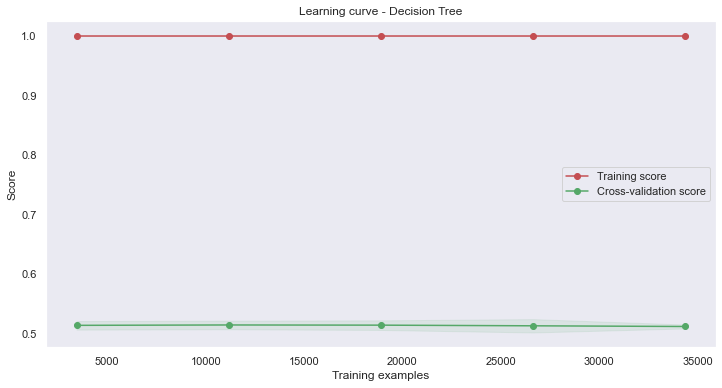

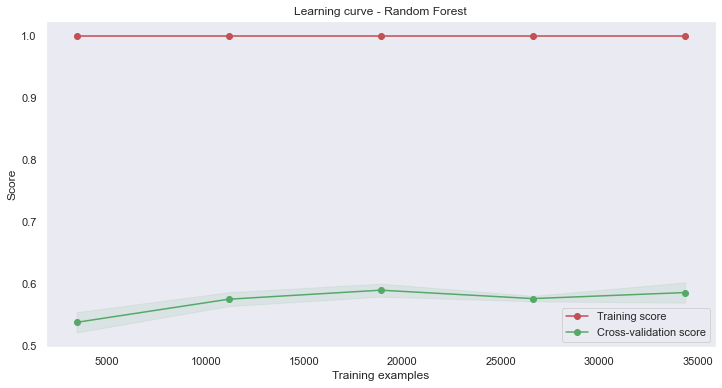

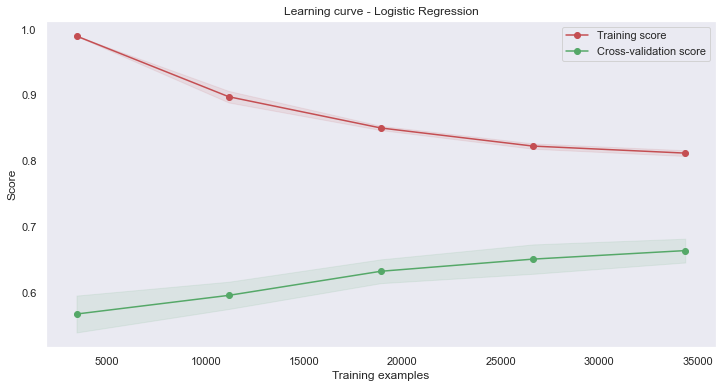

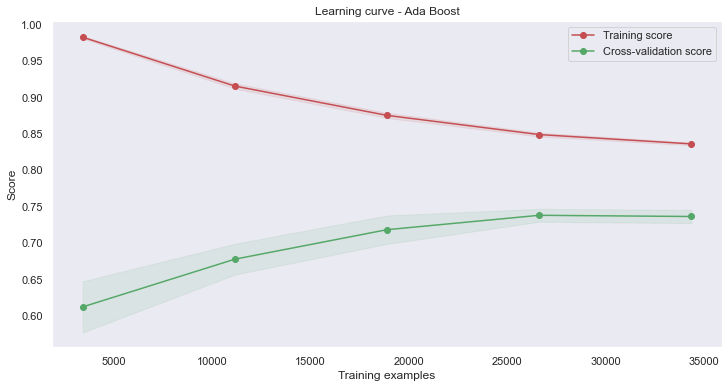

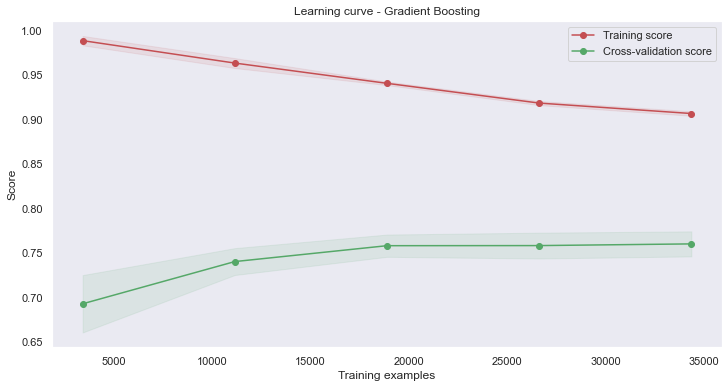

In [85]:
# loop through the previously chosen model dictionary, plot and evalute the performance of each model 

roc_results = {
                'Model':[],
                'ROC_AUC Training Score':[],
                'ROC_AUC Validation Score':[]
                }

X_rand, y_rand = randomize(X, y)

for model_key in models.keys():

    estimator = models.get(model_key)    
    plt, roc_auc_train_score, roc_auc_validation_score = plot_learning_curve(estimator, model_key, X_rand, y_rand)
    roc_results['Model'].append(model_key)
    roc_results['ROC_AUC Training Score'].append(roc_auc_train_score)
    roc_results['ROC_AUC Validation Score'].append(roc_auc_validation_score)
    

In [86]:
# compare model performance in terms of the ROC score

roc_results = pd.DataFrame.from_dict(roc_results, orient='index').transpose()
roc_results

,Model,ROC_AUC Training Score,ROC_AUC Validation Score
0,Decision Tree,1.0,0.512
1,Random Forest,1.0,0.586
2,Logistic Regression,0.812,0.664
3,Ada Boost,0.836,0.737
4,Gradient Boosting,0.907,0.76


**Observation**: The Gradient Boosting classifier out performs other models here.  Although its roc training score is not the highest, its validation score is the highest. The traning and cross valiation learning curves show a converging trend. The curves could converge further with more data provided.  

On the other hand, Decision Tree and Logistic Regression models do not show converging trends in their training and cross validation learning curves. It indicates both estimators are overfitting the models. 

### 2.2 Tuning Parameters

First, let's run a baseline model without tuning 

reference: https://www.datacareer.ch/blog/parameter-tuning-in-gradient-boosting-gbm-with-python/

In [87]:
# see all existing parameters and their default values of the model
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Here, we see that

Tree specific parameters
* n_estimators=100 (number of trees)
* max_depth=3
* min_samples_split=2
* min_samples_leaf=1
* subsample=1.0

Other Parameters
* learning_rate=0.1 (shrinkage)
* subsample: 1

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
from sklearn.metrics import classification_report

Accuracy of the GBM on test set: 0.9859187711
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8472
           1       0.00      0.00      0.00       121

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.97      0.99      0.98      8593



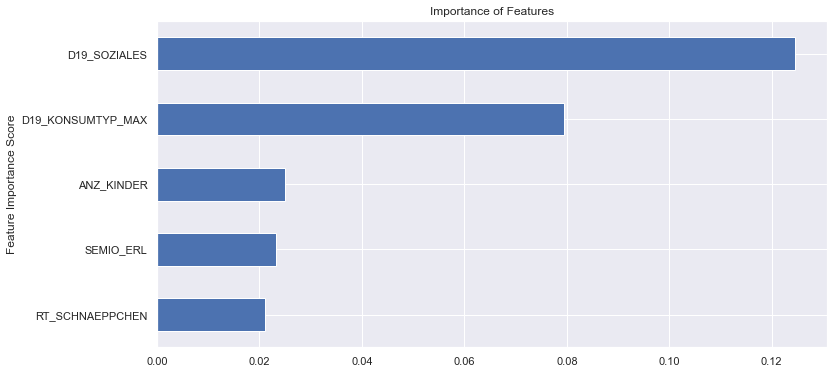

In [117]:
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, 
                                      min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=42)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values()[-5:]
feat_imp.plot(kind='barh', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.10f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

### Tune n_estimators and Learning rate

* n_estimators captures the number of trees that we add to the model 
* generally, there is a trade-off between learning rate and n_estimators 

In [114]:
p_test1 = {'learning_rate':[0.01,0.1,1.0], 'n_estimators':[10, 50, 150, 200]}

tuning1 = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, 
                                                             min_samples_split=2, 
                                                             min_samples_leaf=1, 
                                                             subsample=1,
                                                             max_features='sqrt', 
                                                             random_state=42), 
            param_grid = p_test1, scoring='roc_auc', cv=5)
tuning1.fit(X_train,y_train)
tuning1.best_params_, tuning1.best_score_

({'learning_rate': 0.01, 'n_estimators': 200}, 0.714017213424764)

### Tune max_depth

* max_depth is about the depth of the tree. The maximum depth limits the number of nodes in the tree

In [118]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning2 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,
                                                             n_estimators=200, 
                                                             min_samples_split=2, 
                                                             min_samples_leaf=1, 
                                                             subsample=1,
                                                             max_features='sqrt', 
                                                             random_state=42), 
            param_grid = p_test2, scoring='roc_auc', cv=5)
tuning2.fit(X_train,y_train)
tuning2.best_params_, tuning2.best_score_

({'max_depth': 2}, 0.7469804124815962)

### Tune min_samples_split and min_samples_leaf

Both are tree-specific parameters. 
* min_samples_split: the minimum number of samples required to split an internal node
* min_samples_leaf: the minimum number of samples required to be at a leaf node, it may have effect of smoothing the model

In [119]:
p_test3 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning3 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1, 
                                                             n_estimators=200,
                                                             max_depth=2, 
                                                             subsample=1,
                                                             max_features='sqrt', 
                                                             random_state=42), 
            param_grid = p_test3, scoring='roc_auc', cv=5)
tuning3.fit(X_train,y_train)
tuning3.best_params_, tuning3.best_score_

({'min_samples_leaf': 1, 'min_samples_split': 2}, 0.7469804124815962)

### Tune subsmaple

It is the fraction of samples to be used for fitting the individual base learners. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

In [120]:
p_test4= {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning4 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1, 
                                                             n_estimators=200,
                                                             max_depth=2, 
                                                             min_samples_split=2, 
                                                             min_samples_leaf=1, 
                                                             max_features='sqrt', 
                                                             random_state=42), 
        param_grid = p_test4, scoring='roc_auc', cv=5)
tuning4.fit(X_train,y_train)
tuning4.best_params_, tuning4.best_score_

({'subsample': 0.95}, 0.7486769153826665)

**Observation**: At each tuning step, we see the ROC score is improving

Now, after tuning the parameters, let's create the final model, and check the accruracy

Accuracy of the GBM on test set: 0.9859187711
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8472
           1       0.00      0.00      0.00       121

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.97      0.99      0.98      8593



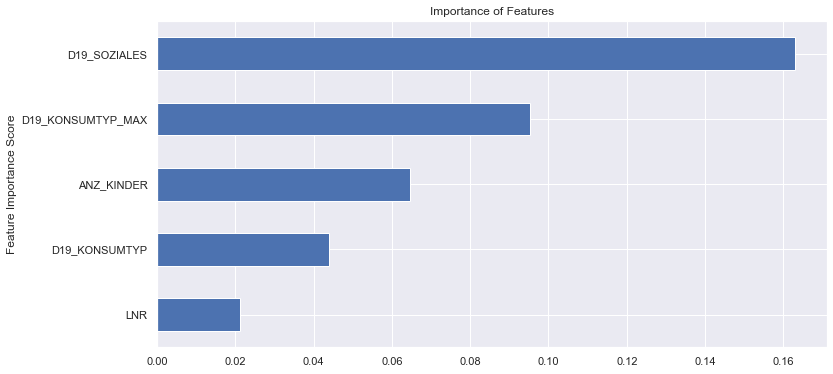

In [121]:
final=GradientBoostingClassifier(learning_rate=0.1, n_estimators=200,max_depth=2, 
                                 min_samples_split=2, min_samples_leaf=1,
                                 max_features='sqrt' , subsample=0.95, random_state=42)
final.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(final.feature_importances_, predictors).sort_values()[-5:]
feat_imp.plot(kind='barh', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.10f}'.format(final.score(X_test, y_test)))
pred=final.predict(X_test)
print(classification_report(y_test, pred))

**Observation**: The accuracy score remains the same after parameter tuning. The accuracy is already very high, so the room for improvement is really limited. In the meantime, out of the top 5 important features, the top 2 features appear to have a lot more impact than the rest of the features. 

### 2.3 Compare ROC AUC 

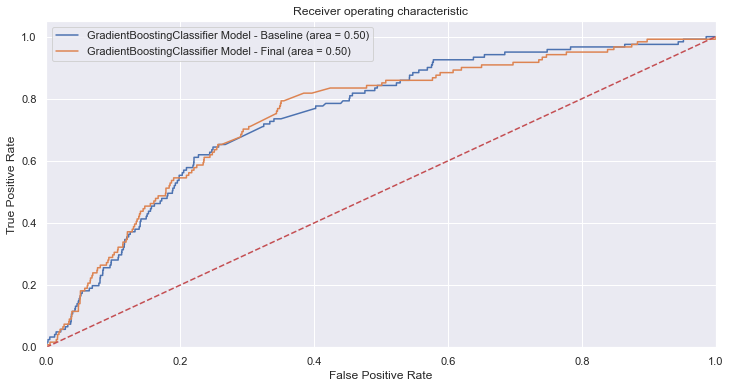

In [122]:
# calculate the values for ROC AUC for the baseline and the final models, and plot their curves

# for the baseline model
baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])


# for the final tuned model 
final_roc_auc = roc_auc_score(y_test, final.predict(X_test))
fprF, tprF, thresholdsF = roc_curve(y_test, final.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GradientBoostingClassifier Model - Baseline (area = %0.2f)' % baseline_roc_auc)

plt.plot(fprF, tprF, label='GradientBoostingClassifier Model - Final (area = %0.2f)' % final_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='best')

plt.show()

**End of the project**